# Goal

My modeling goal within this notebook is to take the Washington Post dataset, specifically the number of pills sent to each county, and ask - So What?

In other words, can the pills sent into a county predict a metric that's used to measure the opioid crisis, namely the number of opioid deaths in that county?

In [1]:
# Imports (I know, there are a lot)

# Data import and manipulation
import pandas as pd
# Math
import numpy as np
# Let's go ahead and seed the notebook, for reproducibility
np.random.seed(113)

# Some statistics, including some checks for normality, skew and correlation
from scipy import stats
from scipy.stats import norm, skew, spearmanr

# Modeling, processing and metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
# unique_label allows the confusion matrix to automatically label itself
from sklearn.utils.multiclass import unique_labels
# XGBoosted modeling library
import xgboost as xgb

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Augmenting sklearn models with visualizations built for them
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features import Rank1D, Rank2D
# Visualization style setting
plt.style.use('seaborn-darkgrid')
sns.set()

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
# Before we begin, defining a few functions to visually evaluate the models
def vis_cm(y_true, y_pred):
    # Takes true values first, then predicted values
    c_mat = confusion_matrix(y_true, y_pred)

    plt.subplots()
    # Visualizes the matrix
    sns.heatmap(c_mat, annot=True, cmap="Blues", fmt='g')

    # Adds title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Adds appropriate axis scales
    class_names = unique_labels(y_true, y_pred)
    tick_marks = np.arange(len(class_names))
    # The +.5 here just centers the labels, red or white, since it's 2x2
    plt.xticks(tick_marks + .5, class_names)
    plt.yticks(tick_marks + .5, class_names)

    plt.show()

# Printing scores for each model
def print_scores(model, X_train, X_test, y_train, y_test, y_pred):
    print("Training Accuracy: {}".format(model.score(X_train, y_train)))
    print("Testing Accuracy: {}".format(model.score(X_test, y_test)))
    print(classification_report(y_test, y_pred))

In [3]:
# Note - I'm just going to start with Pills, to see if I can build a model
# that can predict overdose deaths with just the number of pills from the
# Washington Post/DEA dataset. May add other variables later
data = pd.read_csv("data/TX_County_By_Year.csv", 
                   usecols=["COUNTY", "YEAR", "TOTAL_POPULATION", 
                            "TOTAL_PILLS", "TOTAL_OVERDOSE_DEATHS"])
data.head()

,COUNTY,YEAR,TOTAL_POPULATION,TOTAL_PILLS,TOTAL_OVERDOSE_DEATHS
0,ANDERSON,2006,57386,2209130.0,2.5
1,ANDREWS,2006,13195,246600.0,0.0
2,ANGELINA,2006,83810,3070975.0,2.5
3,ARANSAS,2006,23395,734500.0,2.5
4,ARCHER,2006,9063,0.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Data columns (total 5 columns):
COUNTY                   1778 non-null object
YEAR                     1778 non-null int64
TOTAL_POPULATION         1778 non-null int64
TOTAL_PILLS              1778 non-null float64
TOTAL_OVERDOSE_DEATHS    1778 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 69.5+ KB


In [5]:
data.describe()

,YEAR,TOTAL_POPULATION,TOTAL_PILLS,TOTAL_OVERDOSE_DEATHS
count,1778.000000,1.778000e+03,1.778000e+03,1778.000000
mean,2009.000000,9.745832e+04,3.055180e+06,2.889483
std,2.000563,3.472073e+05,1.179600e+07,15.573713
min,2006.000000,6.100000e+01,0.000000e+00,0.000000
25%,2007.000000,6.644750e+03,1.220800e+05,0.000000
50%,2009.000000,1.824500e+04,4.788050e+05,0.000000
75%,2011.000000,4.898000e+04,1.855902e+06,2.500000
max,2012.000000,4.264193e+06,1.830127e+08,309.000000


### Investigating the Relationship

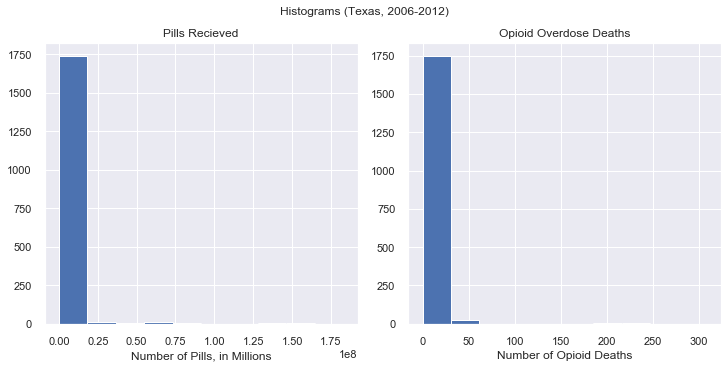

In [6]:
# Let's see the distribution of each variable
fig1, axes = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)

fig1_1 = data["TOTAL_PILLS"].hist(ax=axes[0])
fig1_2 = data["TOTAL_OVERDOSE_DEATHS"].hist(ax=axes[1])

fig1_1.title.set_text("Pills Recieved")
fig1_2.title.set_text("Opioid Overdose Deaths")

fig1_1.set_xlabel("Number of Pills, in Millions")
fig1_2.set_xlabel("Number of Opioid Deaths")
fig1.suptitle("Histograms (Texas, 2006-2012)")

plt.show()

In [7]:
# Defining a list of applicable years, for our widgets
years = list(range(2006,2013))
years

[2006, 2007, 2008, 2009, 2010, 2011, 2012]

In [8]:
# Let's also investigate the relationship
@interact
def plot_pills_vs_deaths(year=years):
    sub_df = data.loc[data["YEAR"] == year]
    
    plt.figure(figsize=(8, 6))

    plt.scatter(x=sub_df["TOTAL_PILLS"], y=sub_df["TOTAL_OVERDOSE_DEATHS"])

    plt.xticks(np.arange(0, 200000000, step=50000000),
               labels=("0", "50M", "100M", "150M"))
    plt.ylabel("Number of Opioid Deaths")
    plt.xlabel("Number of Opioid Pills Received")
    plt.title("Opioid Pills Recieved Versus Opioid Overdose Deaths - Texas, " + str(year))
    plt.show()

interactive(children=(Dropdown(description='year', options=(2006, 2007, 2008, 2009, 2010, 2011, 2012), value=2…

In [9]:
# Plotting another distribution plot, plus a Q-Q plot to check skew
def plot_distribution_skew(year=years):
    sub_df = data.loc[data["YEAR"] == year]

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # By setting fit=norm, we can better compare to a normal distribution
    sns.distplot(sub_df["TOTAL_PILLS"], fit=norm, ax=ax1)
    stats.probplot(sub_df["TOTAL_PILLS"], plot=ax2)

    ax1.set_title("Distribution of Opioid Pills Recieved in " + str(year))
    ax1.set(xlabel="Number of Pills, in Millions", ylabel="Frequency")

    plt.show()


interact(plot_distribution_skew,
         year=widgets.IntSlider(min=2006, max=2012, step=1))
# As you can see, pretty skewed - many outliers

interactive(children=(IntSlider(value=2006, description='year', max=2012, min=2006), Output()), _dom_classes=(…

<function __main__.plot_distribution_skew(year=[2006, 2007, 2008, 2009, 2010, 2011, 2012])>

In [10]:
# Most importantly, let's investigate correlation between these two variables
# Since our data is non-parametric and not noramally distributed, so using
# Spearman's correlation coefficient instead of Pearson's

corr, _ = spearmanr(data["TOTAL_PILLS"], data["TOTAL_OVERDOSE_DEATHS"])
print("Spearman's correlation: %.3f" % corr)

Spearman's correlation: 0.643


A Spearman correlation coefficient of .643 shows a fairly strong positive correlation, but does not show that our data is highly correlated. In short, while you can play around with the annual data scatterplot and infer a linear relationship between our predictor and target variables, they're not so strongly correlated that they have an inherent monotonic relationship - in other words, they are related but not super closely.

### Moving to Classification

So! My data is very much not normal, and I did some behind-the-scenes work trying to normalize this data which did not turn out well. Instead, I'm going to turn this into a classification problem - can the model predict if the number of opioid deaths is above or equals 10? 10 will be my cutoff because it's above my 75% quartile, and the original data was suppressed under 9 (2.5 is a placeholder for that suppressed data, so realistically each '2.5' could be a value between 1 and 9).

In [11]:
data["TARGET"] = data["TOTAL_OVERDOSE_DEATHS"] >= 10
data.head()

,COUNTY,YEAR,TOTAL_POPULATION,TOTAL_PILLS,TOTAL_OVERDOSE_DEATHS,TARGET
0,ANDERSON,2006,57386,2209130.0,2.5,False
1,ANDREWS,2006,13195,246600.0,0.0,False
2,ANGELINA,2006,83810,3070975.0,2.5,False
3,ARANSAS,2006,23395,734500.0,2.5,False
4,ARCHER,2006,9063,0.0,0.0,False


In [12]:
# Checking the class balance
data["TARGET"].value_counts()

False    1686
True       92
Name: TARGET, dtype: int64

In [13]:
# Let's go ahead and remove Total Overdose Deaths
data.drop(columns="TOTAL_OVERDOSE_DEATHS", inplace=True)

In [14]:
# Before we move on, I want to scale the Total Pills by the population to 
# arrive at a per-capita rate. My thought is that this will be a much better 
# at least initial scaler of the data, so it doesn't exaggerate large counties
data["PILLS_PC"] = data["TOTAL_PILLS"] / data["TOTAL_POPULATION"]

In [15]:
data["TARGET"] = data["TARGET"].astype("category")
data["TARGET"] = data["TARGET"].cat.codes

In [16]:
data.head()

,COUNTY,YEAR,TOTAL_POPULATION,TOTAL_PILLS,TARGET,PILLS_PC
0,ANDERSON,2006,57386,2209130.0,0,38.495975
1,ANDREWS,2006,13195,246600.0,0,18.688897
2,ANGELINA,2006,83810,3070975.0,0,36.642107
3,ARANSAS,2006,23395,734500.0,0,31.395597
4,ARCHER,2006,9063,0.0,0,0.000000


In [17]:
data.describe()

,YEAR,TOTAL_POPULATION,TOTAL_PILLS,TARGET,PILLS_PC
count,1778.000000,1.778000e+03,1.778000e+03,1778.000000,1778.000000
mean,2009.000000,9.745832e+04,3.055180e+06,0.051744,27.628911
std,2.000563,3.472073e+05,1.179600e+07,0.221571,18.509325
min,2006.000000,6.100000e+01,0.000000e+00,0.000000,0.000000
25%,2007.000000,6.644750e+03,1.220800e+05,0.000000,15.005555
50%,2009.000000,1.824500e+04,4.788050e+05,0.000000,26.125323
75%,2011.000000,4.898000e+04,1.855902e+06,0.000000,38.866253
max,2012.000000,4.264193e+06,1.830127e+08,1.000000,119.518327


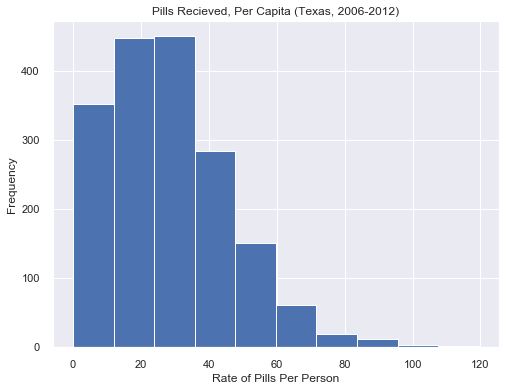

In [18]:
# Let's see the distribution of this new per capita variable
plt.figure(figsize=(8,6))
plt.hist(data["PILLS_PC"])

plt.title("Pills Recieved, Per Capita (Texas, 2006-2012)")
plt.xlabel("Rate of Pills Per Person")
plt.ylabel("Frequency")

plt.show()

### Initial Model - Logistic Regression

Since our problem is binary (will the number of overdose deaths be above 10 in a county that year), let's start with logistic regression.

In [19]:
#Creating variables for our predictor (pills) and our target (overdose deaths)
y_init = data["TARGET"]
X_init = np.array(data["PILLS_PC"]).reshape(-1,1)

In [20]:
# Creating a train/test split to retain data to test our model
X_init_train, X_init_test, y_init_train, y_init_test = train_test_split(
    X_init, y_init, test_size=0.25, random_state=113, stratify=y_init)

In [21]:
# Going ahead and setting class weight as balanced, since the target classes
# are so unbalanced (95% vs 5%, practically)
init_logreg = LogisticRegression(class_weight="balanced",
                            solver="lbfgs", 
                            random_state=113)

# Fitting our model to our training data
init_logreg.fit(X_init_train, y_init_train)
# Storing the predicted values
init_log_preds = init_logreg.predict(X_init_test)

Training Accuracy: 0.5993998499624906
Testing Accuracy: 0.597752808988764
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       422
           1       0.07      0.52      0.12        23

   micro avg       0.60      0.60      0.60       445
   macro avg       0.51      0.56      0.43       445
weighted avg       0.91      0.60      0.71       445



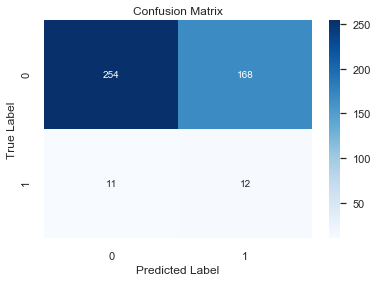

In [22]:
# Using our pre-defined functions to evaluate our model
print_scores(init_logreg, X_init_train, X_init_test,
               y_init_train, y_init_test, init_log_preds)
vis_cm(y_init_test, init_log_preds)

Oof. That is... not great. But, this is using only one predictor variable, and is a simple logistic regression model.

### Another Model: Decision Tree

Let's try a different type of model, to see if model selection alone can improve our model based on this data.

In [23]:
# Starting with a balanced class weight and setting a depth limit
init_dec_tree = DecisionTreeClassifier(max_depth=5,
                                  class_weight="balanced",
                                  random_state=113)

init_dec_tree.fit(X_init_train, y_init_train)
init_tree_preds = init_dec_tree.predict(X_init_test)

Training Accuracy: 0.6241560390097525
Testing Accuracy: 0.5662921348314607
              precision    recall  f1-score   support

           0       0.98      0.55      0.71       422
           1       0.09      0.78      0.16        23

   micro avg       0.57      0.57      0.57       445
   macro avg       0.53      0.67      0.43       445
weighted avg       0.93      0.57      0.68       445



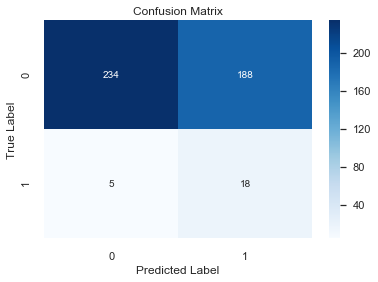

In [24]:
print_scores(init_dec_tree, X_init_train, X_init_test,
             y_init_train, y_init_test, init_tree_preds)
vis_cm(y_init_test, init_tree_preds)

This model actually performed worse on the testing data, so it likely overfit to the training data. Recall scores for the decision tree were, on the whole, better, which is good - I'm more concerned about correctly predicting a true value, meaning there there likely will be more overdose deaths, than a false value.

### And Now: Ensemble Models (Random Forest)

Let's move into an ensemble method for modeling, namely testing with a random forest classifer, to do one last test based on model selection. (I'd also run an XGBoosted model, but haven't done any external work to balance our classes just yet, so I'll stick to methods that allow a class_weight option in the model).

Training Accuracy: 0.6639159789947486
Testing Accuracy: 0.6157303370786517
              precision    recall  f1-score   support

           0       0.98      0.61      0.75       422
           1       0.10      0.78      0.17        23

   micro avg       0.62      0.62      0.62       445
   macro avg       0.54      0.69      0.46       445
weighted avg       0.94      0.62      0.72       445



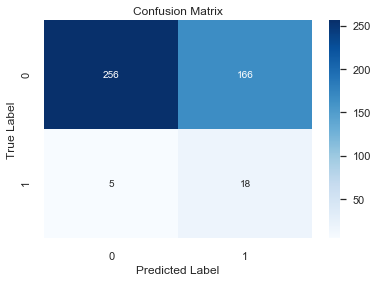

In [25]:
# First, let's run a random forest of small decision trees
init_ran_forest = RandomForestClassifier(n_estimators=100,
                                         max_depth=5,
                                         min_samples_split=3,
                                         class_weight="balanced_subsample",
                                         random_state=113)

init_ran_forest.fit(X_init_train, y_init_train)
init_ran_for_preds = init_ran_forest.predict(X_init_test)

print_scores(init_ran_forest, X_init_train, X_init_test, y_init_train,
             y_init_test, init_ran_for_preds)
vis_cm(y_init_test, init_ran_for_preds)

Better than a single decision tree, including better recall scores.